In [2]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from subprocess import check_output
from keras.utils import plot_model

Using TensorFlow backend.


C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


      Has_Age        Age  Has_Fare  Pclass_1  Pclass_2  Pclass_3  Sex  \
0        True  22.000000      True         0         0         1    1   
1        True  38.000000      True         1         0         0    0   
2        True  26.000000      True         0         0         1    0   
3        True  35.000000      True         1         0         0    0   
4        True  35.000000      True         0         0         1    1   
5       False  29.881138      True         0         0         1    1   
6        True  54.000000      True         1         0         0    1   
7        True   2.000000      True         0         0         1    1   
8        True  27.000000      True         0         0         1    0   
9        True  14.000000      True         0         1         0    0   
10       True   4.000000      True         0         0         1    0   
11       True  58.000000      True         1         0         0    0   
12       True  20.000000      True         0       

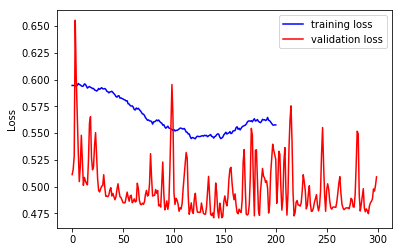

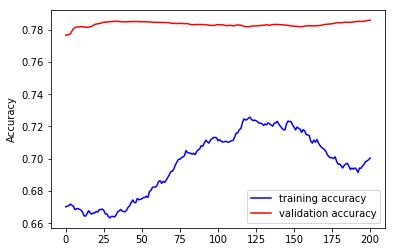

seed 0 crossval accuracy 0.785956581488


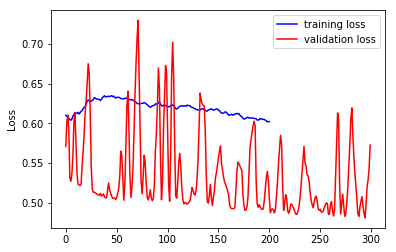

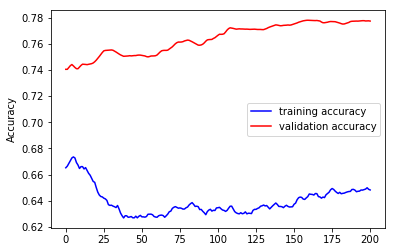

seed 1 crossval accuracy 0.77758932695


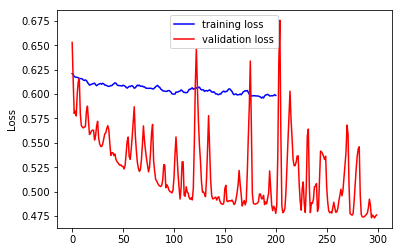

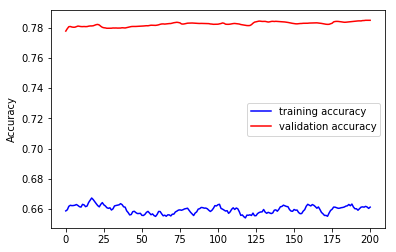

seed 2 crossval accuracy 0.78471280042
seed 0 crossval accuracy 0.791044776901
seed 1 crossval accuracy 0.788858737294
seed 2 crossval accuracy 0.792401628789


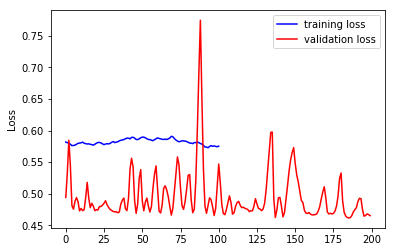

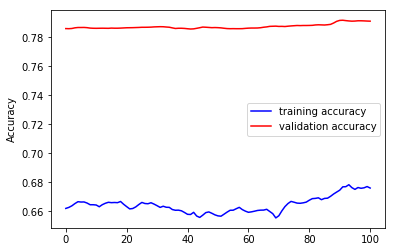

0.791044776901


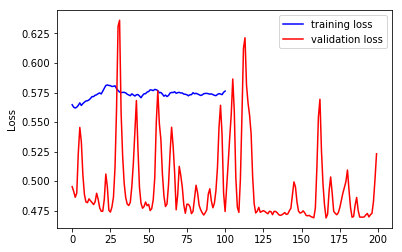

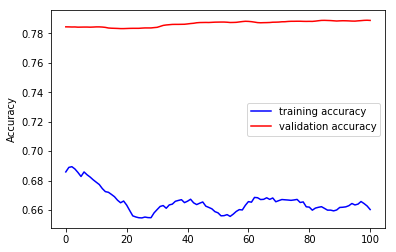

0.788858737294


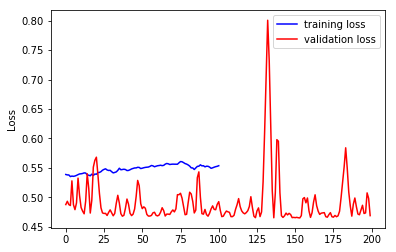

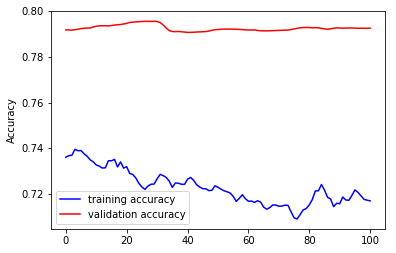

best seed
0.792401628789


In [3]:
# batch for NN
def batch_generator(x_train, y_train, batch_size=256):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1]), dtype='float32')
    y_batch = np.empty((batch_size), dtype='float32')
    
    yes_idx = np.where(y_train == 1.)[0]
    non_idx = np.where(y_train == 0.)[0]
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
        
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch
        
def train_model(model, lr, nb_epochs):
    model.compile(optimizer=Adam(lr), loss = 'binary_crossentropy', metrics=['accuracy'])
    hist = model.fit_generator(batch_generator(train_X, train_y, batch_size), 
                           validation_data=(valid_X, valid_y), 
                           verbose=0, epochs=nb_epochs,
                           steps_per_epoch=train_X.shape[0]//batch_size)
    return model, hist

def plot_hist(hist, N):
    train_loss ,= plt.plot(np.convolve(hist.history['loss'], np.ones((N,))/N, mode='valid'), color='b', label='training loss')
    val_loss ,= plt.plot(hist.history['val_loss'], color='r', label='validation loss')
    plt.ylabel('Loss')
    plt.legend(handles=[train_loss, val_loss])
    plt.show()
    train_acc ,= plt.plot(np.convolve(hist.history['acc'], np.ones((N,))/N, mode='valid'), color='b', label='training accuracy')
    val_acc ,= plt.plot(np.convolve(hist.history['val_acc'], np.ones((N,))/N, mode='valid'), color='r', label='validation accuracy')
    plt.ylabel('Accuracy')
    plt.legend(handles=[train_acc, val_acc])
    plt.show()
    
# try n first seeds
seeds = np.arange(3)

# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
# Create dataset
imputed = pd.DataFrame()
# Fill missing values of Age with the average of Age (mean)
imputed[ 'Has_Age' ] = full.Age.notnull()
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )
# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Has_Fare' ] = full.Fare.notnull()
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }
# Get names
name = pd.DataFrame()
name['Name'] = full[ 'Name' ].map( lambda name: name.split( ',' )[0].strip() )

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )

cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )



# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )



family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed.drop('Fare', axis=1) , pclass , sex , family, title, ticket ] , axis=1 )
full_X.head()

# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ].as_matrix()
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

train_X = train_X.as_matrix()
valid_X = valid_X.as_matrix()
train_y = train_y.as_matrix()
valid_y = valid_y.as_matrix()

#print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)
print (full_X)
#print (train_X)
#print (test_X)


hists = []
models = []
promising_seeds = []

# rapidly test seeds and keep promising ones
for a_seed in seeds:
    # create model
    model = Sequential()
    model.add(Dense(train_X.shape[1]+10, activation='relu',input_shape=train_X.shape[1:]))
    #model.add(Dropout(0.1))
    model.add(Dense(30, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    batch_size = 256
    # random seed
    np.random.seed(a_seed)
    #Start with a slightly lower learning rate, to ensure convergence
    model, hist = train_model(model, 6e-4, 200)
    # faster convergence
    model, hist = train_model(model, 9e-4, 300)
    hists.append(hist)
    models.append(model)
    plot_hist(hist, 100)
    print("seed", a_seed, "crossval accuracy", np.mean(hist.history['val_acc'][-100:-1]))
    # if the model has reach at least 55% cross validation accuracy
    if np.mean(hist.history['val_acc'][-100:-1]) > 0.55:
        promising_seeds.append(a_seed)
        
# train promising models
best_seed = 0
best_acc = 0.0
# not using good seeds at the moment
good_seeds = []
for a_seed in promising_seeds:
    # add some convergence time
    models[a_seed], hists[a_seed] = train_model(models[a_seed], 9e-4, 200)
    acc = np.mean(hists[a_seed].history['val_acc'][-100:-1])
    print("seed", a_seed, "crossval accuracy", acc)
    if acc >0.6:
        good_seeds.append(a_seed)
    if acc > best_acc:
        best_seed = a_seed
        best_acc = acc
        
# draw all models to check if we kept the best  
for a_seed in seeds:
    hist = hists[a_seed]
    plot_hist(hist, 100)
    if a_seed == best_seed:
        print("best seed")
    print(np.mean(hist.history['val_acc'][-100:-1]))
    
plot_model(model, to_file='titanic_model.png', show_shapes=True, show_layer_names=True)  
